#  Spike PAtterns DEtection using SPADE


In [8]:
import numpy as np
import quantities as pq
import neo
import elephant
import viziphant
np.random.seed(4542)

## introducing heterogeneous delays

the function developed in the scan + a shift in time

In [9]:
t_stop = 10*pq.s
slope = 1.
A_sync = 0.05
shift = 0.0
A = [0]+[1.-A_sync]+[0]*8+[A_sync]
spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=10*pq.s)
                             


Add a shift:

In [10]:
spiketrains[0].times + 4.2*pq.s

array([ 4.5428428 ,  4.56964823,  5.42303783,  5.48863725,  5.83905792,
        7.08270894,  7.23516076,  7.23817857,  7.61886987,  7.66763254,
        8.03237276,  8.05699453,  8.37892833,  8.38912792,  8.70264362,
        9.31709083,  9.45194019,  9.52478839, 10.59516735, 10.70198542,
       11.12936517, 11.18985003, 11.30209661, 11.35895706, 11.76589684,
       11.98118491, 12.44170386, 12.51116287, 12.69874386, 12.90570514,
       13.11675734, 13.17507227, 13.23423901, 13.23853449, 13.35468654,
       13.59298729, 13.72941963, 13.81571811, 14.1134528 ]) * s

Wrap around time:

In [11]:
np.sort(np.mod(spiketrains[0].times + 4.2*pq.s, 10*pq.s))

array([0.59516735, 0.70198542, 1.12936517, 1.18985003, 1.30209661,
       1.35895706, 1.76589684, 1.98118491, 2.44170386, 2.51116287,
       2.69874386, 2.90570514, 3.11675734, 3.17507227, 3.23423901,
       3.23853449, 3.35468654, 3.59298729, 3.72941963, 3.81571811,
       4.1134528 , 4.5428428 , 4.56964823, 5.42303783, 5.48863725,
       5.83905792, 7.08270894, 7.23516076, 7.23817857, 7.61886987,
       7.66763254, 8.03237276, 8.05699453, 8.37892833, 8.38912792,
       8.70264362, 9.31709083, 9.45194019, 9.52478839]) * s

Sort in time:

In [12]:
np.sort(np.mod(spiketrains[0].times + 4.2*pq.s, 10*pq.s))

array([0.59516735, 0.70198542, 1.12936517, 1.18985003, 1.30209661,
       1.35895706, 1.76589684, 1.98118491, 2.44170386, 2.51116287,
       2.69874386, 2.90570514, 3.11675734, 3.17507227, 3.23423901,
       3.23853449, 3.35468654, 3.59298729, 3.72941963, 3.81571811,
       4.1134528 , 4.5428428 , 4.56964823, 5.42303783, 5.48863725,
       5.83905792, 7.08270894, 7.23516076, 7.23817857, 7.61886987,
       7.66763254, 8.03237276, 8.05699453, 8.37892833, 8.38912792,
       8.70264362, 9.31709083, 9.45194019, 9.52478839]) * s

https://neo.readthedocs.io/en/stable/core.html?highlight=spiketrain#example-spiketrain

In [13]:
neo.SpikeTrain(np.sort(np.mod(spiketrains[0].times + 4.2*pq.s, 10*pq.s)), t_start=0*pq.s, t_stop=10*pq.s)



SpikeTrain

In [14]:
for i_st in range(10):
    delay = (i_st*slope)*pq.s
    spike_times = np.sort(np.mod(spiketrains[i_st].times + delay, t_stop))
    spiketrains[i_st] = neo.SpikeTrain(spike_times, t_start=0*pq.s, t_stop=t_stop)

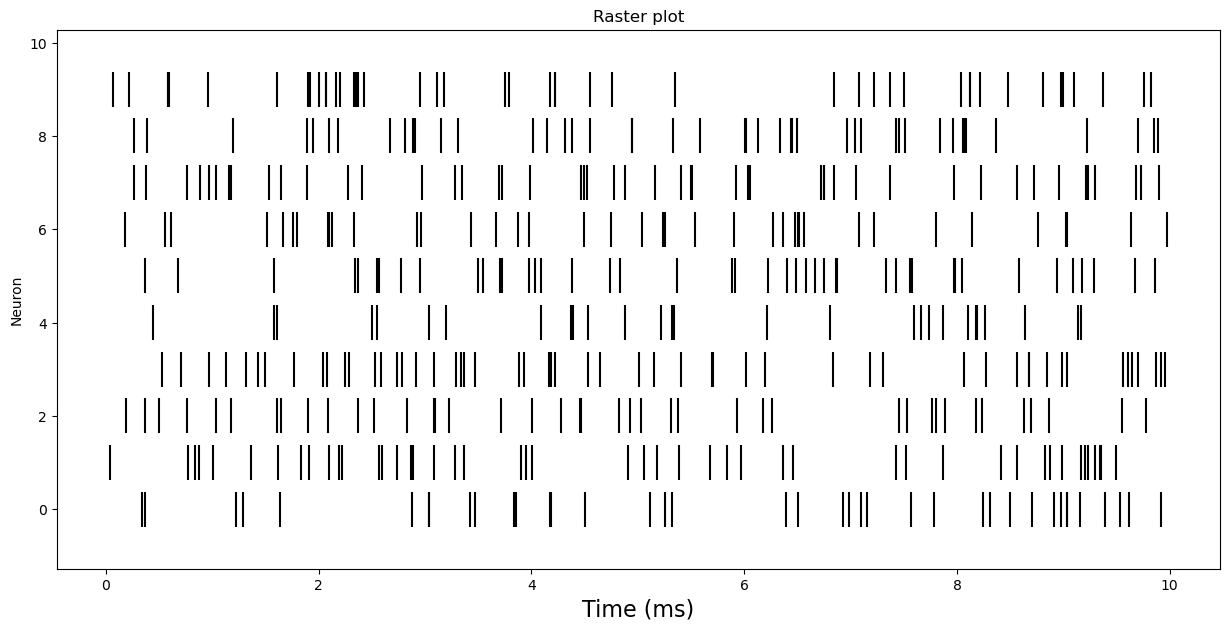

In [15]:

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.eventplot([spiketrains[i].magnitude for i in range(len(spiketrains))], linelengths=0.75, color='black')
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('Neuron')
plt.title("Raster plot");

All in one function:

In [16]:

def generate_and_test(A_sync=A_sync, shift=shift, winlen=1, slope=slope, t_stop=t_stop):

    A = [0]+[1.-A_sync]+[0]*8+[A_sync]
    spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=t_stop)
    for i_st in range(10):
        delay = (i_st*slope)*pq.s
        spike_times = np.sort(np.mod(spiketrains[i_st].times + delay, t_stop))
        spiketrains[i_st] = neo.SpikeTrain(spike_times, t_start=0*pq.s, t_stop=t_stop)

    for i in range(90):
        spiketrains.append(elephant.spike_train_generation.homogeneous_poisson_process(
            rate=5*pq.Hz, t_stop=10*pq.s))
    patterns = elephant.spade.spade(
                                spiketrains=spiketrains, binsize=1*pq.ms, winlen=winlen, min_spikes=3,
                                n_surr=100, dither=5*pq.ms,
                                psr_param=[0,0,0],
                                output_format='patterns')['patterns']
    return patterns


* changing the synchrony probability to check when SPADE will begin to fail:


In [17]:
for slope_ in np.logspace(-1, 1, 10, base=10):
    patterns = generate_and_test(slope=slope_)
    print(slope_, patterns)

/Users/laurentperrinet/opt/anaconda3/envs/brainhack/lib/python3.9/site-packages/elephant/spade.py:679: UserWarning: Optimized C implementation of FCA (fim.so/fim.pyd) not found in elephant/spade_src folder, or not compatible with this Python version. You are using the pure Python implementation of fast fca.
  warnings.warn(


Time for data mining: 10.692577123641968


In [ ]:
for slope_ in np.logspace(-1, 1, 10, base=10):
    patterns = generate_and_test(slope=slope_, winlen=10)
    print(slope_, patterns)